In [8]:
import modal
from modal_colabfold import generate_a3m_files
import pandas as pd
from binder_design import EGFS, FOLD_RESULTS_DIR, PEPMLM_RESULTS_DIR, DATA_DIR
from binder_design.utils import get_mutation_diff, hash_seq
from datetime import datetime
%load_ext autoreload
%autoreload 2

fold = modal.Function.lookup("colabfold", 'fold_and_extract')
parallel_fold = modal.Function.lookup("colabfold", 'parallel_fold_and_extract')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def mutate_seq(seq, position, new_aa):
    return seq[:position-1] + new_aa + seq[position:]

def apply_mutation(seq, mutation_str):
    new_aa = mutation_str[-1]
    position = int(mutation_str[:-1])
    return mutate_seq(seq, position, new_aa)

egfs = 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRDLRWW'

mutations = [
    '2W',
    '2A',
    # '2B',
    # '2C',
    ]
seqs = {}
for mutation in mutations:
    seq = apply_mutation(egfs, mutation)
    seqs[f'egfs_{mutation}'] = seq
    
results = list(parallel_fold.remote(binder_sequences=seqs, batch_size=1, num_recycle=1, num_models=1))
fold_df['mut_str'] = fold_df['binder_sequence'].apply(get_mutation_diff, seq2=EGFS)
fold_df['seq_name'] = fold_df['binder_sequence'].apply(hash_seq)
now = datetime.now().strftime('%Y%m%d_%H%M%S')
fp = FOLD_RESULTS_DIR / f'fold_results_{now}.csv'
# save the fold_df
fold_df.to_csv(fp, index=False)

In [4]:
# generate_a3m_files(
#     binder_sequences=seqs,
#     output_folder='test',
#     )

In [64]:

results = fold.remote(binder_sequences=seqs)

In [68]:
fold_df = pd.DataFrame(results)

In [74]:
fold_df['mut_str'] = fold_df['binder_sequence'].apply(get_mutation_diff, seq2=EGFS)
fold_df['seq_name'] = fold_df['binder_sequence'].apply(hash_seq)
now = datetime.now().strftime('%Y%m%d_%H%M%S')
fp = FOLD_RESULTS_DIR / f'fold_results_{now}.csv'
# save the fold_df
fold_df.to_csv(fp, index=False)

In [4]:
results = list(parallel_fold.remote(binder_sequences=seqs, batch_size=1, num_recycle=1, num_models=1))

In [5]:
fold_df = pd.DataFrame(results)

In [6]:
fold_df

,seq_name,binder_sequence,target_sequence,binder_length,target_length,model_number,binder_plddt,binder_pae,pae_interaction,ptm,seq_id,pdb_content
0,egfs_2W,NWYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,86.3494,4.57626,9.260557,0.84,8a6e27,MODEL 1 ...
1,egfs_2A,NAYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,86.6950,4.53488,9.224025,0.84,bdeb0c,MODEL 1 ...


In [7]:
fold_df['seq_name'] = fold_df['binder_sequence'].apply(hash_seq)
fold_df = fold_df.sort_values(by='pae_interaction', ascending=True).reset_index(drop=True)
fold_df['generation'] = None

# Save the fold results
now = datetime.now().strftime('%Y%m%d_%H%M%S')
fp = FOLD_RESULTS_DIR / f'fold_results_{now}.csv'
fold_df.to_csv(fp, index=False)

NameError: name 'logger' is not defined

In [11]:
import pandas as pd
df = pd.DataFrame(results)

In [14]:
df.groupby('seq_name')['pae_interaction'].mean()

seq_name
egfs_2C    9.170334
egfs_2W    9.060102
Name: pae_interaction, dtype: float64

In [40]:
pepmlms = pd.read_csv('/Users/alex/code/binder_design/data/pepmlm_binders_gen1_20240818_032509.csv')

In [32]:
pepmlms['name'] = 'EGFS__' + pepmlms['mutation'].str.replace(',', '_')

In [33]:
seqs = pepmlms.set_index('name')['binder'].head(4).to_dict()

In [34]:
seqs

{'EGFS__L15G_I35H_L47G': 'NSYPGCPSSYDGYCGNGGVCMHIESLDSYTCNCVHGYSGDRCQTRDGRWW',
 'EGFS__M21T_I35P': 'NSYPGCPSSYDGYCLNGGVCTHIESLDSYTCNCVPGYSGDRCQTRDLRWW',
 'EGFS__P7L_L15A_I35P': 'NSYPGCLSSYDGYCANGGVCMHIESLDSYTCNCVPGYSGDRCQTRDLRWW',
 'EGFS__V34A_I35H_W50L': 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCAHGYSGDRCQTRDLRWL'}

In [35]:
pepmlm_results = list(parallel_fold.remote(binder_sequences=seqs, batch_size=1))

In [38]:
pepmlm_df = pd.DataFrame(pepmlm_results)

In [39]:
pepmlm_df.groupby('seq_name')['pae_interaction'].mean()

seq_name
EGFS__L15G_I35H_L47G    10.088727
EGFS__M21T_I35P          9.313959
EGFS__P7L_L15A_I35P      9.592177
EGFS__V34A_I35H_W50L     8.707573
Name: pae_interaction, dtype: float64

In [32]:
import re

csvs = list(PEPMLM_RESULTS_DIR.glob('*.csv'))
dfs = []
for csv in csvs:
    _df = pd.read_csv(csv)
    match = re.search(r'gen(\d+)', str(csv))
    if match:
        gen_num = int(match.group(1))
    else:
        gen_num = None
    _df['generation'] = gen_num
    dfs.append(_df)
pepmlm_df = pd.concat(dfs).sort_values('ppl').reset_index(drop=True)

In [43]:
pepmlm_df['mutation'] = pepmlm_df['binder'].apply(get_mutation_diff, seq2=EGFS)

<Axes: xlabel='generation', ylabel='ppl'>

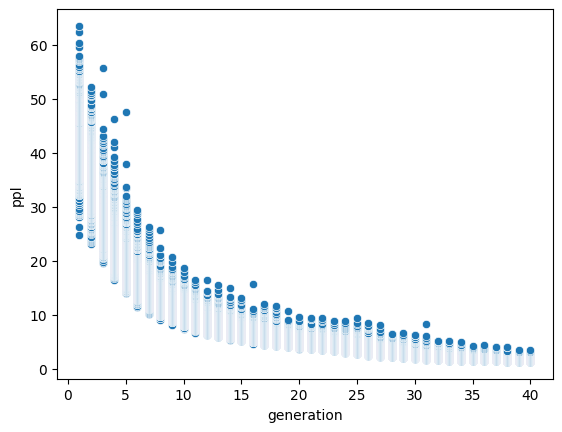

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pepmlm_df, x='generation', y='ppl')


<Axes: xlabel='generation', ylabel='ppl'>

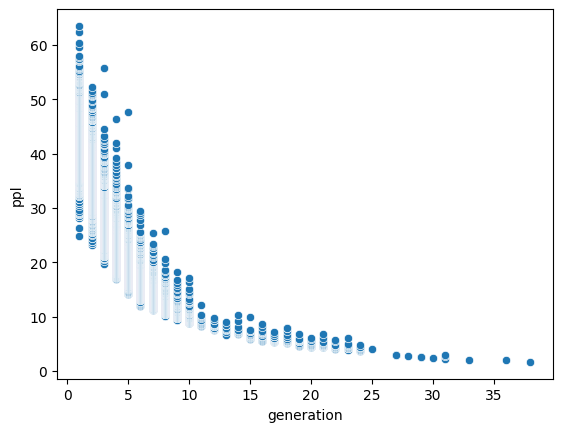

In [35]:
sns.scatterplot(data=pepmlm_df[~pepmlm_df.binder.str.contains('X')], x='generation', y='ppl')

In [44]:
good_df = pepmlm_df[~pepmlm_df.binder.str.contains('X')]

In [52]:
filtered = good_df.query('generation == 1').drop_duplicates(subset=['binder']).sort_values('ppl', ascending=True).head(10)
new_binders = filtered['binder'].to_list()
filtered

,target_seq,parent_binder,binder,ppl,mask_positions,mutation,timestamp,generation
57186,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCGNGGVCMHIESLDSYTCNCVHGYSGDRCQTRD...,24.861686,"14,34,46","G15L,H35I,G47L",2024-08-18 10:24:29,1
57646,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGGVCTHIESLDSYTCNCVPGYSGDRCQTRD...,26.225159,"24,20,34","T21M,P35I",2024-08-18 10:24:33,1
58129,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCLSSYDGYCANGGVCMHIESLDSYTCNCVPGYSGDRCQTRD...,28.072532,"14,6,34","L7P,A15L,P35I",2024-08-18 10:24:41,1
58222,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCAHGYSGDRCQTRD...,28.450214,"33,34,49","A34V,H35I,L50W",2024-08-18 10:24:36,1
58223,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRHQTRV...,28.453512,"41,34,45","P35I,H42C,V46D",2024-08-18 10:24:41,1
58257,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NHYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRCATRD...,28.604040,"1,34,42","H2S,P35I,A43Q",2024-08-18 10:24:23,1
58301,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVHGYSGDRCQTRD...,28.810567,"34,48","H35I,T49W",2024-08-18 10:42:11,1
58319,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGSVCMHIESLDSYTCNCVPGYSGDRCQTRD...,28.901980,"17,34","S18G,P35I",2024-08-18 10:42:13,1
58340,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRVQTRE...,28.980745,"45,34,41","P35I,V42C,E46D",2024-08-18 10:25:08,1
58375,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVIGYSGDRCQTRD...,NSYPGCKSSYPGYCLNGGVCMHIESLDSYTCNCVPGYSGDRCQTRD...,29.151650,"10,6,34","K7P,P11D,P35I",2024-08-18 10:24:33,1


In [55]:
new_binders

{'52a69d': 'NSYPGCPSSYDGYCGNGGVCMHIESLDSYTCNCVHGYSGDRCQTRDGRWW',
 '219bfb': 'NSYPGCPSSYDGYCLNGGVCTHIESLDSYTCNCVPGYSGDRCQTRDLRWW',
 '6d4273': 'NSYPGCLSSYDGYCANGGVCMHIESLDSYTCNCVPGYSGDRCQTRDLRWW',
 'dcc405': 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCAHGYSGDRCQTRDLRWL',
 '507cf0': 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRHQTRVLRWW',
 'fe1047': 'NHYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRCATRDLRWW',
 '2ef3f1': 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVHGYSGDRCQTRDLRTW',
 '7d4364': 'NSYPGCPSSYDGYCLNGSVCMHIESLDSYTCNCVPGYSGDRCQTRDLRWW',
 '93bc7b': 'NSYPGCPSSYDGYCLNGGVCMHIESLDSYTCNCVPGYSGDRVQTRELRWW',
 '97adf3': 'NSYPGCKSSYPGYCLNGGVCMHIESLDSYTCNCVPGYSGDRCQTRDLRWW'}

In [53]:
new_binders = {hash_seq(binder): binder for binder in new_binders}

In [ ]:
results = parallel_fold.remote(binder_sequences=new_binders, num_models=1, batch_size=1)

In [ ]:
fold_df = pd.DataFrame(results)
fold_df['mut_str'] = fold_df['binder_sequence'].apply(get_mutation_diff, seq2=EGFS)
fold_df['seq_name'] = fold_df['binder_sequence'].apply(hash_seq)
now = datetime.now().strftime('%Y%m%d_%H%M%S')
fp = FOLD_RESULTS_DIR / f'fold_results_{now}.csv'
fold_df.to_csv(fp, index=False)

In [56]:
fold_df

,seq_name,binder_sequence,target_sequence,binder_length,target_length,model_number,binder_plddt,binder_pae,pae_interaction,ptm,pdb_content,mut_str
0,1d1721,NAYPGCPGSFDGYCPNGGVCTHIESTDCFTCECLPGYSGDTVHTRA...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,37.0852,12.068828,22.015410,0.60,MODEL 1 ...,"A2S,G8S,F10Y,P15L,T21M,T26L,C28S,F29Y,E32N,L34..."
1,9fc068,NSLPCCPSSHGGYGLNGGVCCNIESTDTFECACVPGYSGDRPQTRV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,56.5372,8.842028,16.364958,0.68,MODEL 1 ...,"L3Y,C5G,H10Y,G11D,G14C,C21M,N22H,T26L,T28S,F29..."
2,9430c3,NSTECAPGSAGGHPGNAGVCCHVNSTDTFKCACLPGYYGDRPVNSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,30.4460,13.991156,21.947171,0.64,MODEL 1 ...,"T3Y,E4P,C5G,A6C,G8S,A10Y,G11D,H13Y,P14C,G15L,A..."
3,149cbb,NSYPGLPNNPDGYCPNGGVCMSIDSTDSYTCCCTHGYHGDRCATRD...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,57.8370,9.141732,16.006051,0.70,MODEL 1 ...,"L6C,N8S,N9S,P10Y,P15L,S22H,D24E,T26L,C32N,T34V..."
4,e20ea1,NSTGCAPGSGGGLPGNHGVCCHVVSTDTFQCACLPGYSGDRPQNSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,27.8352,14.069144,23.577893,0.57,MODEL 1 ...,"T3Y,G4P,C5G,A6C,G8S,G10Y,G11D,L13Y,P14C,G15L,H..."
5,94b29d,NSYPCCPSSYGGSCLNGGVCEHIESTDNYTCACKPGYYGDRPLNSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,35.1764,12.529700,21.267938,0.66,MODEL 1 ...,"C5G,G11D,S13Y,E21M,T26L,N28S,A32N,K34V,P35I,Y3..."
6,99a35e,GSYPDCASSCTGYCPNGGVCMAIESTDSFTCKCVPGYSGDRPHTSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,45.2740,12.152336,18.508359,0.70,MODEL 1 ...,"G1N,D5G,A7P,C10Y,T11D,P15L,A22H,T26L,F29Y,K32N..."
7,839eac,NSYPCCPSSYGGYCPNGGVCEHIESTDSFTCACKPGYSGDRPHTSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,51.9468,10.576700,17.104109,0.71,MODEL 1 ...,"C5G,G11D,P15L,E21M,T26L,F29Y,A32N,K34V,P35I,P4..."
8,74506d,NSTLCAPGSGGGAPGNGGVCMHINSTDTFQCACLPGYSGDRPQNSV...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,29.3748,13.723640,23.481551,0.55,MODEL 1 ...,"T3Y,L4P,C5G,A6C,G8S,G10Y,G11D,A13Y,P14C,G15L,N..."
9,2b92d8,NSYPDCPSSCGGYCPNGGVCKAVESTDCFTCACVPGYSGDRPHTSI...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,50,622,1,47.2914,12.001808,18.026546,0.71,MODEL 1 ...,"D5G,C10Y,G11D,P15L,K21M,A22H,V23I,T26L,C28S,F2..."
